Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import re
import random
from collections import defaultdict, Counter
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
corpus = [
    "Large Language Models (LLMs) are powerful deep learning systems trained on massive datasets to understand and generate human-like text.",
    "The architecture of most state-of-the-art LLMs, such as GPT and BERT, is based on the transformer model, which uses self-attention mechanisms to process sequential data.",
    "Training an LLM involves processing vast amounts of text data, often scraped from the internet, to learn statistical patterns in language.",
    "These models are capable of performing a variety of natural language processing tasks including translation, summarization, question answering, and code generation.",
    "While early LLMs were primarily used in research settings, modern LLMs are now embedded into consumer applications, chatbots, search engines, and virtual assistants.",
    "Despite their impressive capabilities, LLMs often produce outputs that are grammatically correct but factually incorrect, a phenomenon known as hallucination.",
    "Fine-tuning allows developers to adapt a pre-trained LLM to specific tasks or domains by training it further on a smaller, targeted dataset.",
    "One of the key advantages of LLMs is their ability to perform zero-shot or few-shot learning, making accurate predictions from limited examples.",
    "The context window of an LLM defines how much information it can consider at once, with recent models supporting several thousand tokens of input.",
    "Tokenization is a crucial preprocessing step in LLMs, where raw text is broken into manageable pieces (tokens) that the model can understand.",
    "LLMs rely on large-scale parallel processing hardware, such as GPUs or TPUs, to train efficiently across billions of parameters.",
    "Ethical concerns surrounding LLMs include potential misuse for generating disinformation, impersonation, and reinforcing harmful biases.",
    "Mitigating bias in LLMs is an ongoing challenge, requiring both better training data and improved evaluation techniques.",
    "LLMs trained on general corpora may lack domain-specific knowledge, necessitating fine-tuning or retrieval-augmented generation techniques.",
    "Some LLMs incorporate external tools or plugins to extend their capabilities beyond language, such as calling APIs or performing calculations.",
    "Transformer-based LLMs process input text in parallel rather than sequentially, improving computational efficiency compared to older RNNs.",
    "Attention heads in a transformer model help the LLM focus on different parts of the input sequence when making predictions.",
    "Self-supervised learning, the backbone of LLM training, enables the model to learn from raw text without requiring labeled data.",
    "Prompt engineering is a technique to guide LLM outputs by carefully crafting the input query to elicit the desired response.",
    "LLMs exhibit emergent behaviors, where capabilities suddenly appear as the model size surpasses a certain threshold.",
    "Multimodal LLMs like GPT-4o can process text, images, and even audio, unlocking more diverse and complex applications.",
    "Inference in LLMs involves generating output by sampling from the model’s probability distribution over possible next tokens.",
    "Deterministic decoding strategies like greedy search and beam search provide consistent outputs but can reduce creativity.",
    "Sampling-based decoding techniques such as top-k and nucleus sampling offer more diverse and human-like text generation.",
    "Temperature is a hyperparameter in decoding that controls the randomness of the model’s outputs, affecting creativity and diversity.",
    "Open-source LLMs like LLaMA and Mistral have democratized access to cutting-edge models, encouraging innovation in research and development.",
    "Many LLMs now support instruction tuning, making them more responsive and aligned with user intents during dialogue.",
    "Despite impressive capabilities, LLMs lack true understanding and operate as pattern recognition systems rather than reasoning agents.",
    "Researchers are exploring hybrid models that combine LLMs with symbolic reasoning to overcome their limitations in logic and abstraction.",
    "Training LLMs raises environmental concerns due to the large carbon footprint associated with high-performance computing resources.",
    "Quantization is a technique to reduce LLM model size and inference cost by using lower precision formats like int8 instead of float32.",
    "Distillation creates smaller, faster models by training a compact student model to imitate the behavior of a larger teacher model.",
    "Alignment refers to ensuring LLM behavior matches human values and intentions, often enforced through reinforcement learning with human feedback.",
    "Evaluating LLMs is complex, requiring metrics that capture fluency, relevance, factual accuracy, and safety of generated content.",
    "LLMs can be integrated into retrieval-augmented generation systems to combine language generation with factual grounding from external sources.",
    "Guardrails and moderation systems are essential when deploying LLMs to filter out unsafe, harmful, or toxic content.",
    "The rapid development of LLMs is reshaping industries such as education, healthcare, law, and entertainment.",
    "Personalized LLM applications tailor responses to individual users by incorporating memory and user preference profiles.",
    "The performance of LLMs can vary significantly depending on the prompt phrasing, input format, and task instructions.",
    "Cross-lingual LLMs are trained on multiple languages and can translate or generate text across different linguistic systems.",
    "Some LLMs are optimized for low-resource languages to bridge the digital divide and enable global AI access.",
    "Model interpretability remains a major research area, as LLMs are often seen as black boxes with limited transparency.",
    "Tools like attention visualization and feature attribution are being developed to provide insights into LLM decision-making.",
    "LLMs are susceptible to adversarial attacks, where inputs are crafted to trick the model into producing incorrect outputs.",
    "Security risks include prompt injection, where a user manipulates input prompts to subvert intended model behavior.",
    "Federated learning and on-device LLMs are emerging to enhance user privacy by keeping data local and decentralized.",
    "LLMs may inadvertently memorize and reproduce sensitive data from their training sets, raising privacy and legal concerns.",
    "Despite being trained for text, LLMs show surprising ability to reason over structured data like tables and code.",
    "The future of LLMs likely involves combining them with tools, memory, reasoning modules, and autonomous agents.",
    "Developers must remain vigilant and thoughtful when integrating LLMs, balancing innovation with ethical responsibility."
]

# Example: print first 5 lines
print(corpus[:5])
corpus = ''.join(corpus)

['Large Language Models (LLMs) are powerful deep learning systems trained on massive datasets to understand and generate human-like text.', 'The architecture of most state-of-the-art LLMs, such as GPT and BERT, is based on the transformer model, which uses self-attention mechanisms to process sequential data.', 'Training an LLM involves processing vast amounts of text data, often scraped from the internet, to learn statistical patterns in language.', 'These models are capable of performing a variety of natural language processing tasks including translation, summarization, question answering, and code generation.', 'While early LLMs were primarily used in research settings, modern LLMs are now embedded into consumer applications, chatbots, search engines, and virtual assistants.']


 2.1 Preparing a Simple Dataset

In [ ]:
# Clean the text
corpus = corpus.strip().lower()
sentences = [s.strip() for s in corpus.split('.') if s.strip()]
print(f"Number of sentences: {len(sentences)}")
print(f"Sample sentence: {sentences[0]}")


Number of sentences: 50
Sample sentence: large language models (llms) are powerful deep learning systems trained on massive datasets to understand and generate human-like text


2.2 Implementing a Simple Tokenizer

In [ ]:
class BPETokenizer:
    def __init__(self, vocab_size=1000, unk_token="<unk>"):
        self.vocab_size = vocab_size
        self.unk_token = unk_token
        self.bpe_codes = {}
        self.token_to_id = {}
        self.id_to_token = {}

    def get_stats(self, tokens):
        """Compute frequencies of adjacent symbol pairs."""
        pairs = defaultdict(int)
        for word, freq in tokens.items():
            symbols = word.split()
            for i in range(len(symbols) - 1):
                pairs[(symbols[i], symbols[i+1])] += freq
        return pairs

    def merge_vocab(self, pair, tokens):
        """Merge the most frequent pair into a single token."""
        new_tokens = {}
        bigram = ' '.join(pair)
        replacement = ''.join(pair)
        for word in tokens:
            new_word = word.replace(bigram, replacement)
            new_tokens[new_word] = tokens[word]
        return new_tokens

    def fit(self, texts):
        # Step 1: Build initial vocabulary of characters
        tokens = Counter()
        for text in texts:
            for word in text.strip().split():
                tokens[' '.join(list(word)) + ' </w>'] += 1  # </w> denotes end of word

        # Step 2: Perform BPE merges
        while len(self.bpe_codes) < self.vocab_size:
            pairs = self.get_stats(tokens)
            if not pairs:
                break
            most_freq = max(pairs, key=pairs.get)
            self.bpe_codes[most_freq] = len(self.bpe_codes)
            tokens = self.merge_vocab(most_freq, tokens)

        # Step 3: Build token-to-id mappings
        subwords = set()
        for word in tokens:
            subwords.update(word.split())
        subwords = sorted(list(subwords))
        self.token_to_id = {token: idx for idx, token in enumerate(subwords)}
        self.token_to_id[self.unk_token] = len(self.token_to_id)
        self.id_to_token = {idx: token for token, idx in self.token_to_id.items()}
        return self

    def encode_word(self, word):
        symbols = list(word) + ['</w>']
        while True:
            # 1) If there are fewer than 2 symbols, stop.
            if len(symbols) < 2:
                break

            # 2) Build all adjacent pair scores
            pairs = [(symbols[i], symbols[i+1]) for i in range(len(symbols) - 1)]
            merge_candidates = {
                pair: self.bpe_codes.get(pair, float('inf'))
                for pair in pairs
            }

            # 3) If none of those pairs is actually in your codes, stop.
            best_pair, best_score = min(merge_candidates.items(), key=lambda kv: kv[1])
            if best_score == float('inf'):
                break

            # 4) Otherwise merge and repeat.
            i = pairs.index(best_pair)
            symbols = symbols[:i] + [''.join(best_pair)] + symbols[i+2:]

        # map to ids…
        return [self.token_to_id.get(sym, self.token_to_id[self.unk_token])
                for sym in symbols]


    def encode(self, text):
        tokens = []
        for word in text.strip().split():
            tokens.extend(self.encode_word(word))
        return tokens

    def decode(self, ids):
        tokens = [self.id_to_token.get(idx, self.unk_token) for idx in ids]
        words = []
        current_word = ""

        for token in tokens:
            if token == self.unk_token:
                continue  # skip unknown tokens
            if token.endswith("</w>"):
                current_word += token.replace("</w>", "")
                words.append(current_word)
                current_word = ""
            else:
                current_word += token
        if current_word:
            words.append(current_word)

        return ' '.join(words)


    def __len__(self):
        return len(self.token_to_id)

 # Create and fit the tokenizer
tokenizer = BPETokenizer().fit(sentences)
print(f"Vocabulary size: {len(tokenizer)}")
# Test encoding and decoding
sample_text = sentences[0]
encoded = tokenizer.encode(sample_text)
decoded = tokenizer.decode(encoded)
print(f"Original: {sample_text}")
print(f"Encoded: {encoded}...")
print(f"Decoded: {decoded}")

Vocabulary size: 567
Original: large language models (llms) are powerful deep learning systems trained on massive datasets to understand and generate human-like text
Encoded: [286, 283, 329, 0, 566, 566, 365, 566, 566, 201, 124, 566, 566, 479, 517, 351, 566, 566, 566, 566, 4, 443, 530, 507, 566, 566, 566, 566, 28, 28, 566, 40, 566, 566, 566, 566, 3, 296, 493]...
Decoded: large language models (llms) pful deep systems trained on asets to and and at-like text


In [ ]:
class WordTokenizer:
    def __init__(self, min_frequency=2):
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.vocab_size = 0
        self.min_frequency = min_frequency
        self.unk_token = ""

    def fit(self, texts):
        words = set()
        for text in texts:
            for word in text.split(' '):
                words.add(word)
        sorted_words = sorted(words)
        self.word_to_idx = {word: idx for idx, word in enumerate(sorted_words)}
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}
        self.vocab_size = len(self.word_to_idx)
        return self

    def encode(self, text):
        return [self.word_to_idx[word] for word in text.split(' ')]

    def decode(self, indices):
        words = [self.idx_to_word[idx] for idx in indices]
        return ' '.join(words)

    def __len__(self):
        return self.vocab_size
 # Create and fit the tokenizer
tokenizer = WordTokenizer().fit(sentences)
print(f"Vocabulary size: {len(tokenizer)}")
# Test encoding and decoding
sample_text = sentences[0]
encoded = tokenizer.encode(sample_text)
decoded = tokenizer.decode(encoded)
print(f"Original: {sample_text}")
print(f"Encoded: {encoded}...")
print(f"Decoded: {decoded}")

Vocabulary size: 498
Original: large language models (llms) are powerful deep learning systems trained on massive datasets to understand and generate human-like text
Encoded: [250, 247, 289, 0, 27, 340, 104, 255, 431, 462, 310, 276, 100, 453, 473, 20, 176, 200, 441]...
Decoded: large language models (llms) are powerful deep learning systems trained on massive datasets to understand and generate human-like text


2.3 Creating Training Data

In [ ]:
def prepare_data(sentences, tokenizer, seq_length=20):
    """Prepare input-output pairs for training"""
    inputs = []
    targets = []
    for sentence in sentences:
        # Skip sentences that are too short
        words = sentence.split(' ')
        if len(words) <= seq_length + 1:
            continue

        # Tokenize the sentence
        tokens = tokenizer.encode(sentence)
        # Create input-target pairs with a sliding window
        for i in range(len(tokens) - seq_length):
            input_seq = tokens[i:i+seq_length]
            target_seq = tokens[i+1:i+seq_length+1]  # Next token prediction

            inputs.append(input_seq)
            targets.append(target_seq)

    # Convert to PyTorch tensors
    inputs = torch.tensor(inputs, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)

    return inputs, targets
 # Prepare training data
seq_length = 10
inputs, targets = prepare_data(sentences, tokenizer, seq_length)
print(f"Number of training examples: {len(inputs)}")
print(f"Input shape: {inputs.shape}")
print(f"Target shape: {targets.shape}")
# Sample data point
idx = 0
print(f"Sample input: {tokenizer.decode(inputs[idx].tolist())}")
print(f"Sample target: {tokenizer.decode(targets[idx].tolist())}")

Number of training examples: 412
Input shape: torch.Size([412, 10])
Target shape: torch.Size([412, 10])
Sample input: large language models (llms) are powerful deep learning systems trained
Sample target: language models (llms) are powerful deep learning systems trained on


 2.4 Implementing the Embedding Layer

In [ ]:
class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(EmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embed_dim = embed_dim

    def forward(self, x):
        # x shape: (batch_size, seq_length)
        # output shape: (batch_size, seq_length, embed_dim)
        return self.embedding(x) * (self.embed_dim ** 0.5)  # Scaling factor
 # Test the embedding layer
vocab_size = len(tokenizer)
embed_dim = 32
embedding_layer = EmbeddingLayer(vocab_size, embed_dim)
sample_batch = inputs[:3]  # Take 3 examples
embedded = embedding_layer(sample_batch)
print(f"Sample batch shape: {sample_batch.shape}")
print(f"Embedded output shape: {embedded.shape}")

Sample batch shape: torch.Size([3, 10])
Embedded output shape: torch.Size([3, 10, 32])


2.5 Implementing Positional Encoding

Shape after positional encoding: torch.Size([3, 10, 32])


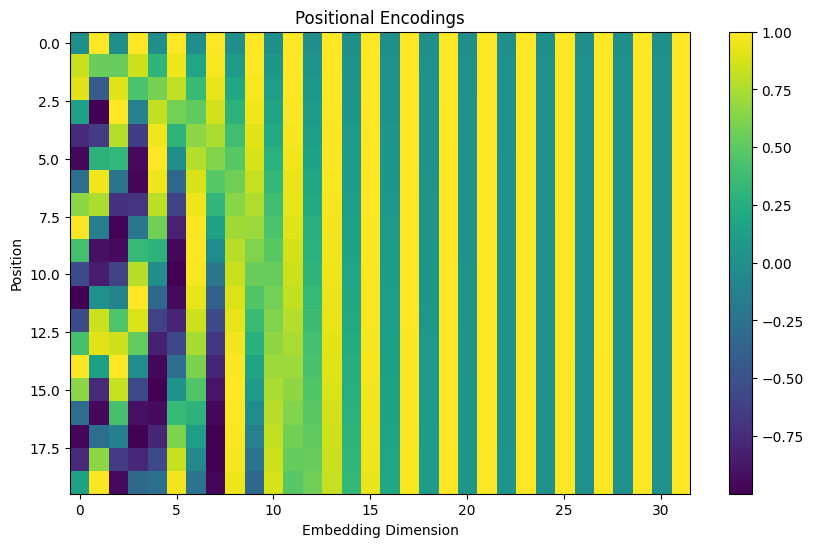

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_seq_length=5000):
        super(PositionalEncoding, self).__init__()

        # Create positional encoding matrix
        pe = torch.zeros(max_seq_length, embed_dim)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-np.log(10000.0) / embed_dim))

        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register as buffer (not model parameter)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x shape: (batch_size, seq_length, embed_dim)
        # Add positional encoding
        return x + self.pe[:, :x.size(1), :]
 # Test positional encoding
pos_encoding = PositionalEncoding(embed_dim)
embedded_with_pos = pos_encoding(embedded)
print(f"Shape after positional encoding: {embedded_with_pos.shape}")
 # Visualize positional encodings
plt.figure(figsize=(10, 6))
plt.imshow(pos_encoding.pe[0, :20, :].cpu().numpy(), aspect='auto', cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.colorbar()
plt.title('Positional Encodings')
plt.show()

 2.6 Implementing Self-Attention Mechanism

Attention output shape: torch.Size([3, 10, 32])
Attention weights shape: torch.Size([3, 4, 10, 10])


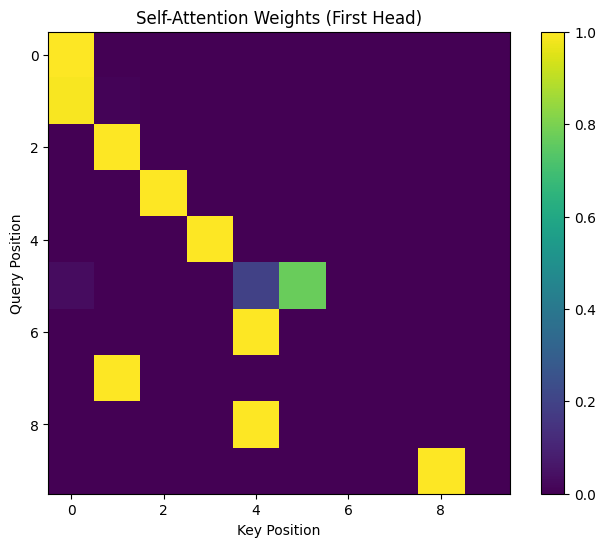

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        # Single linear projection for Q, K, V
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, mask=None):
        B, T, E = x.size()  # Batch size, Seq length, Embedding dim

        # Project and split Q, K, V in one go: (B, T, 3 * E)
        qkv = self.qkv(x)  # (B, T, 3 * E)
        qkv = qkv.reshape(B, T, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, num_heads, T, head_dim)
        queries, keys, values = qkv[0], qkv[1], qkv[2]  # Each: (B, num_heads, T, head_dim)

        # Scaled Dot-Product Attention
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (B, num_heads, T, T)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))

        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, values)  # (B, num_heads, T, head_dim)

        # Merge heads
        out = out.transpose(1, 2).reshape(B, T, E)  # (B, T, embed_dim)
        out = self.fc_out(out)  # Final linear projection

        return out, attn
 # Create causal mask for language modeling
def create_causal_mask(size):
    mask = torch.tril(torch.ones(size, size))
    return mask.unsqueeze(0).unsqueeze(0)  # (1, 1, size, size)
 # Test self-attention
num_heads = 4
attention = SelfAttention(embed_dim, num_heads)
mask = create_causal_mask(seq_length).to(device)
attention_output, attention_weights = attention(embedded_with_pos, mask)
print(f"Attention output shape: {attention_output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
# Visualize attention weights for the first head
plt.figure(figsize=(8, 6))
plt.imshow(attention_weights[0, 0, :, :].detach().cpu().numpy(), cmap='viridis')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.colorbar()
plt.title('Self-Attention Weights (First Head)')
plt.show()

 2.7 Implementing Feed-Forward Network

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, ff_dim):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, embed_dim)
        self.activation = nn.GELU()  # GELU activation as used in modern transformers

    def forward(self, x):
        # x shape: (batch_size, seq_length, embed_dim)
        x = self.fc1(x)  # (batch_size, seq_length, ff_dim)
        x = self.activation(x)
        x = self.fc2(x)  # (batch_size, seq_length, embed_dim)
        return x
 # Test feed-forward network
ff_dim = embed_dim * 4  # Common practice to use 4x the embedding dimension
feed_forward = FeedForward(embed_dim, ff_dim)
ff_output = feed_forward(attention_output)
print(f"Feed-forward output shape: {ff_output.shape}")

Feed-forward output shape: torch.Size([3, 10, 32])


2.8 Implementing a Transformer Block

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()

        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = SelfAttention(embed_dim, num_heads)
        self.dropout1 = nn.Dropout(dropout)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, ff_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Pre-LN before attention
        norm_x = self.norm1(x)
        attention_output, _ = self.attention(norm_x, mask)
        x = x + self.dropout1(attention_output)  # Residual connection

        # Pre-LN before feed-forward
        norm_x = self.norm2(x)
        ff_output = self.feed_forward(norm_x)
        x = x + self.dropout2(ff_output)  # Residual connection

        return x

embed_dim = 32
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
block_output = transformer_block(embedded_with_pos, mask)
print(f"Transformer block output shape: {block_output.shape}")
 # Test transformer block
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
block_output = transformer_block(embedded_with_pos, mask)
print(f"Transformer block output shape: {block_output.shape}")

Transformer block output shape: torch.Size([3, 10, 32])
Transformer block output shape: torch.Size([3, 10, 32])


 2.9 Implementing the Complete Mini Language Model

In [ ]:
class MiniLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, max_seq_length, dropout=0.1):
        super(MiniLanguageModel, self).__init__()

        self.embed_dim = embed_dim
        self.embedding = EmbeddingLayer(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_seq_length)

        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)]
        )

        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Create causal mask
        seq_length = x.shape[1]
        mask = create_causal_mask(seq_length).to(x.device)

        # Embedding and positional encoding
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.dropout(x)

        # Transformer blocks
        for block in self.transformer_blocks:
            x = block(x, mask)

        # Output layer
        x = self.fc_out(x)  # (batch_size, seq_length, vocab_size)

        return x
 # Model hyperparameters
vocab_size = len(tokenizer)
embed_dim = 64
num_heads = 4
ff_dim = embed_dim * 4
num_layers = 2
max_seq_length = 100
dropout = 0.1
 # Initialize the model
model = MiniLanguageModel(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_layers=num_layers,
    max_seq_length=max_seq_length,
    dropout=dropout
).to(device)
 # Print model summary
print(model)
 # Test forward pass
sample_batch = inputs[:5].to(device)  # Take 5 examples
output = model(sample_batch)
print(f"Model output shape: {output.shape}")  # Should be (batch_size, seq_length, vocab_size)

MiniLanguageModel(
  (embedding): EmbeddingLayer(
    (embedding): Embedding(498, 64)
  )
  (positional_encoding): PositionalEncoding()
  (transformer_blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attention): SelfAttention(
        (qkv): Linear(in_features=64, out_features=192, bias=True)
        (fc_out): Linear(in_features=64, out_features=64, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (feed_forward): FeedForward(
        (fc1): Linear(in_features=64, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=64, bias=True)
        (activation): GELU(approximate='none')
      )
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (fc_out): Linear(in_features=64, out_features=498, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Model output shape: torch.Size([5, 10, 498

2.10 Training the Model

Epoch 1/10, Batch 0/7, Loss: 14.8223
Epoch 1/10, Average Loss: 14.6781
Epoch 2/10, Batch 0/7, Loss: 14.0658
Epoch 2/10, Average Loss: 13.8252
Epoch 3/10, Batch 0/7, Loss: 13.5231
Epoch 3/10, Average Loss: 12.9773
Epoch 4/10, Batch 0/7, Loss: 12.6657
Epoch 4/10, Average Loss: 12.3143
Epoch 5/10, Batch 0/7, Loss: 11.9884
Epoch 5/10, Average Loss: 11.5953
Epoch 6/10, Batch 0/7, Loss: 11.0408
Epoch 6/10, Average Loss: 10.9530
Epoch 7/10, Batch 0/7, Loss: 10.3636
Epoch 7/10, Average Loss: 10.3406
Epoch 8/10, Batch 0/7, Loss: 10.3193
Epoch 8/10, Average Loss: 9.7268
Epoch 9/10, Batch 0/7, Loss: 9.5214
Epoch 9/10, Average Loss: 9.1890
Epoch 10/10, Batch 0/7, Loss: 9.0085
Epoch 10/10, Average Loss: 8.5790


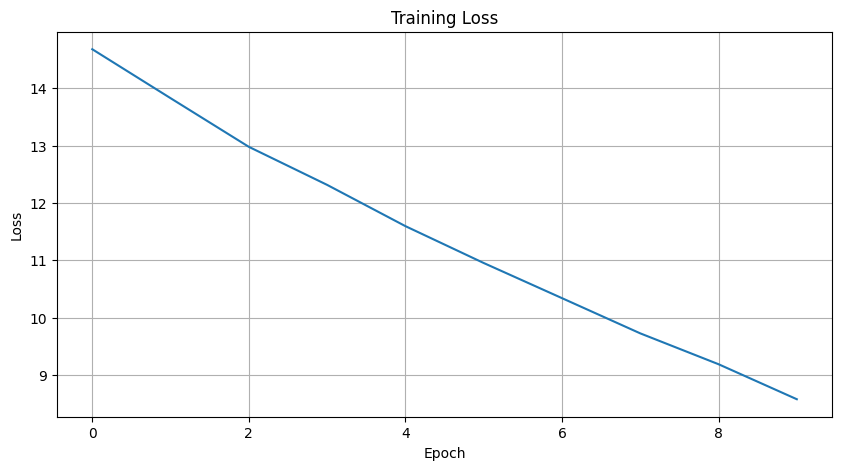

In [ ]:
def train_model(model, inputs, targets, batch_size=32, epochs=10, lr=3e-4):
    """Train the language model"""
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Create dataset and dataloader
    dataset = torch.utils.data.TensorDataset(inputs, targets)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    model.train()
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (batch_inputs, batch_targets) in enumerate(dataloader):
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(batch_inputs)

            # Reshape outputs and targets for loss computation
            outputs = outputs.reshape(-1, vocab_size)  # (batch_size * seq_length, vocab_size)
            batch_targets = batch_targets.reshape(-1)  # (batch_size * seq_length)

            # Compute loss
            loss = criterion(outputs, batch_targets)

            # Backward pass and optimization
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

            epoch_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}")

        avg_epoch_loss = epoch_loss / len(dataloader)
        losses.append(avg_epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_epoch_loss:.4f}")

    return losses
 # For the lab, we'll use a very small number of epochs
epochs = 10
batch_size = 64
losses = train_model(model, inputs, targets, batch_size=batch_size, epochs=epochs)
 # Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

2.11 Generating Text with the Model

In [ ]:
def generate_text(model, tokenizer, prompt, max_length=100, temperature=1.0):
    """Generate text using the trained model"""
    model.eval()

    # Tokenize the prompt
    prompt_tokens = tokenizer.encode(prompt)
    input_ids = torch.tensor(prompt_tokens).unsqueeze(0).to(device)  # (1, prompt_length)

    # Generate text
    generated = list(prompt_tokens)

    with torch.no_grad():
        for _ in range(max_length):
            # Take the last seq_length tokens if input is too long
            if input_ids.size(1) > seq_length:
                input_ids = input_ids[:, -seq_length:]

            # Forward pass
            outputs = model(input_ids)

            # Get the next token probabilities
            next_token_logits = outputs[:, -1, :] / temperature

            # Sample from the distribution
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            # Add the next token to the sequence
            input_ids = torch.cat([input_ids, next_token], dim=1)
            generated.append(next_token.item())

            # Stop if we generate the end of sentence token (if you have one)
            # if next_token.item() == eos_token_id:
            #     break

    # Convert back to text
    generated_text = tokenizer.decode(generated)

    return generated_text
 # Generate text
prompt = "llms are"
generated_text = generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_length=12,
    temperature=0.8
)
print(f"Prompt: {prompt}")
print(f"Generated text: {generated_text}")

Prompt: llms are
Generated text: llms are modules, several heads cross-lingual teacher balancing by training on understand language limited


 Exercise 1: Implement a Word-Level Tokenizer

 Exercise 2: Add Layer Normalization

Exercise 3: Implement Multi-Head Attention with Matrix Multiplication

Exercise 4: Performance Optimization

 Exercise 5: Experiment with Hyperparameters